In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score

/home/pk/.local/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Importing the Data

In [2]:
df = pd.read_csv('Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Understanding the Data

In [3]:
col_names = df.columns.values
col_names

array(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'Churn'], dtype=object)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

In [5]:
df.TotalCharges = pd.to_numeric(df.TotalCharges, errors='coerce')
df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [6]:
df.dropna(inplace = True)
df = df.iloc[:, 1:]

Deleting the rows where churning value is null as it has no use to train the model.
Dropping the 'customerID' column as it has no use in predicting the results.

## Data Manipulation

Most of the columns has categorical data, thus converting the values of the columns to binary values.

In [7]:
df.gender = [1 if gender == "Male" else 0 for gender in df.gender]

col_to_convert = ['Partner',
                  'Dependents', 
                  'PhoneService', 
                  'MultipleLines', 
                  'OnlineSecurity',
                  'OnlineBackup',
                  'DeviceProtection',
                  'TechSupport',
                  'StreamingTV',
                  'StreamingMovies',
                  'PaperlessBilling',
                  'Churn'
                 ]

for column in col_to_convert:
    df[column] = [1 if item == 'Yes' else 0 for item in df[column]]
    
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,0,DSL,0,1,0,0,0,0,Month-to-month,1,Electronic check,29.85,29.85,0
1,1,0,0,0,34,1,0,DSL,1,0,1,0,0,0,One year,0,Mailed check,56.95,1889.50,0
2,1,0,0,0,2,1,0,DSL,1,1,0,0,0,0,Month-to-month,1,Mailed check,53.85,108.15,1
3,1,0,0,0,45,0,0,DSL,1,0,1,1,0,0,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,0,0,0,0,2,1,0,Fiber optic,0,0,0,0,0,0,Month-to-month,1,Electronic check,70.70,151.65,1


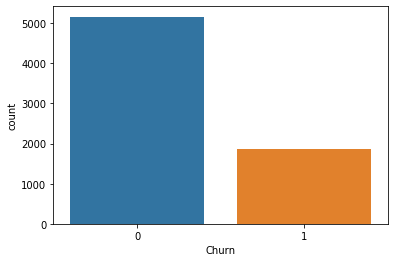

In [8]:
sns.countplot(x='Churn', data=df)

Text(0.5, 1, 'Correlation between Variables')

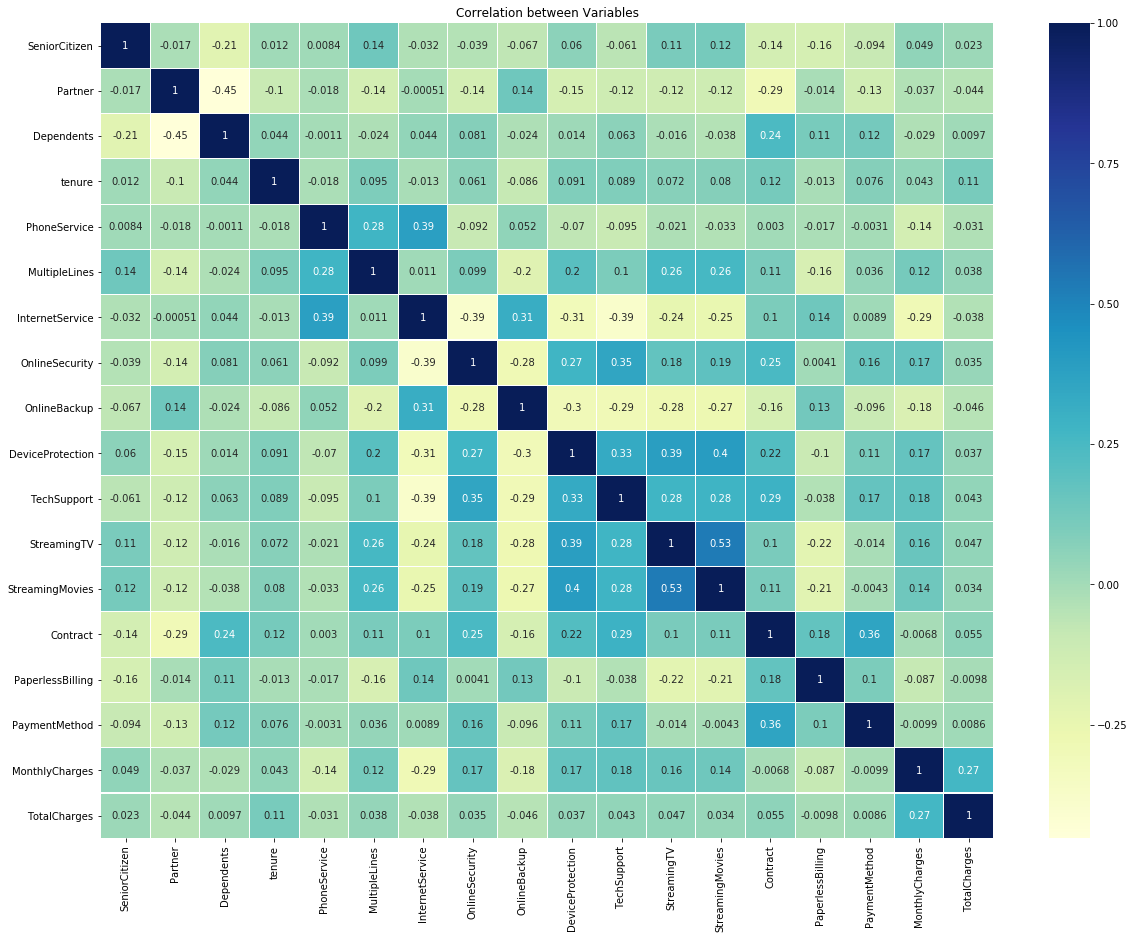

In [9]:
plt.figure(figsize=(20,15))
corr = df.iloc[:, 1:19].apply(lambda x: pd.factorize(x)[0]).corr()
sns.heatmap(corr, annot=True, cmap='YlGnBu', xticklabels=corr.columns, yticklabels=corr.columns, linewidths=.2)
plt.title("Correlation between Variables")

Text(0.5, 1, 'Churn Internet Service')

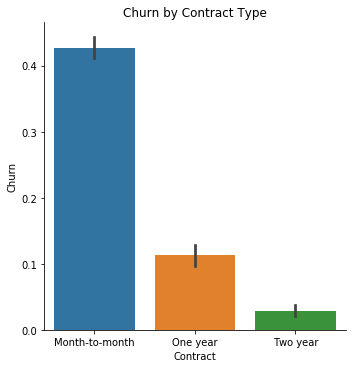

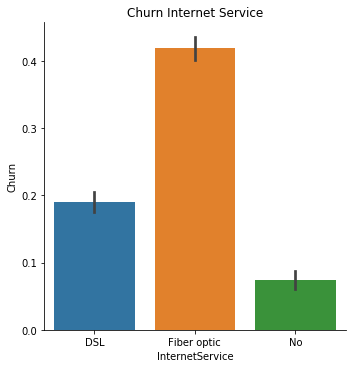

In [10]:
sns.catplot(x="Contract", y="Churn", data=df, kind="bar")
plt.title("Churn by Contract Type")

sns.catplot(x="InternetService", y="Churn", data=df, kind="bar")
plt.title("Churn Internet Service")

People having Month-to-Month contract type are tend to churn more than those having a longer duration contract type.
Similarly people with Fibre optic contract type tend to churn more than people having DSL type Internet Service.



In [11]:
data = pd.get_dummies(data=df)
data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,0,0,1,0,...,1,0,0,1,0,0,0,0,1,0
1,1,0,0,0,34,1,0,1,0,1,...,1,0,0,0,1,0,0,0,0,1
2,1,0,0,0,2,1,0,1,1,0,...,1,0,0,1,0,0,0,0,0,1
3,1,0,0,0,45,0,0,1,0,1,...,1,0,0,0,1,0,1,0,0,0
4,0,0,0,0,2,1,0,0,0,0,...,0,1,0,1,0,0,0,0,1,0


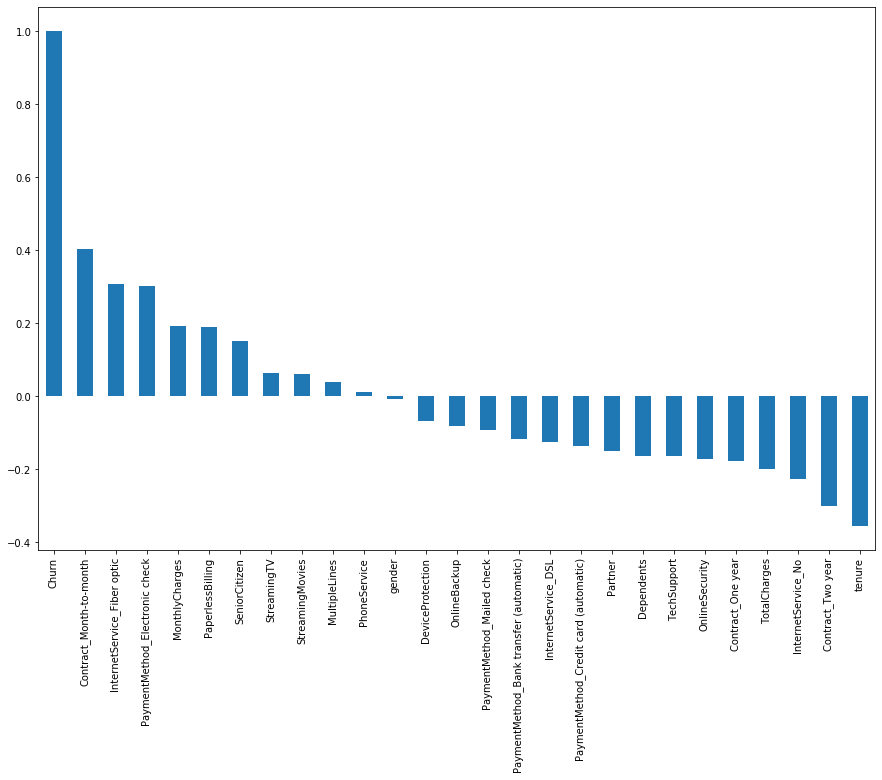

In [12]:
plt.figure(figsize=(15,10))
data.corr()['Churn'].sort_values(ascending=False).plot(kind='bar')

Comparing the correlations of the features with the Churn feature to check the effect of the features on the churning of the customer.
As we can see from the graph above that the correlation between Churn and gender & PhoneService is very close to Zero, thus these features can be ignored while training our model to predict the Churn.

In [13]:
data.drop(['PhoneService'], axis = 1, inplace=True)
data.drop(['gender'], axis = 1, inplace=True)

Text(0.5, 1.0, 'Distribution of monthly charges by churn')

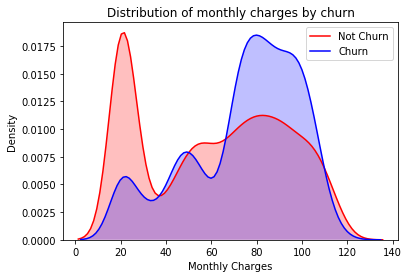

In [14]:
ax = sns.kdeplot(data.MonthlyCharges[(df["Churn"] == 0) ],
                color="Red", shade = True)
ax = sns.kdeplot(data.MonthlyCharges[(df["Churn"] == 1) ],
                ax =ax, color="Blue", shade= True)
ax.legend(["Not Churn","Churn"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Monthly Charges')
ax.set_title('Distribution of monthly charges by churn')

Text(0.5, 1.0, 'Distribution of total charges by churn')

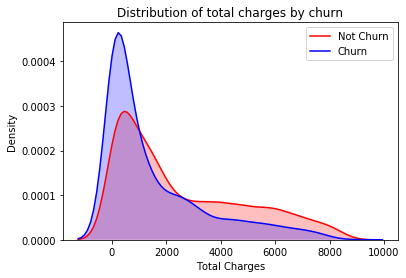

In [15]:
ax = sns.kdeplot(data.TotalCharges[(df["Churn"] == 0) ],
                color="Red", shade = True)
ax = sns.kdeplot(data.TotalCharges[(df["Churn"] == 1) ],
                ax =ax, color="Blue", shade= True)
ax.legend(["Not Churn","Churn"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Total Charges')
ax.set_title('Distribution of total charges by churn')

Text(0.5, 1.0, 'Distribution of tenure by churn')

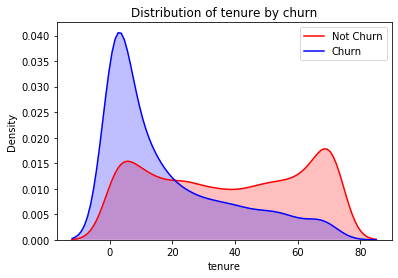

In [16]:
ax = sns.kdeplot(data.tenure[(df["Churn"] == 0) ],
                color="Red", shade = True)
ax = sns.kdeplot(data.tenure[(df["Churn"] == 1) ],
                ax =ax, color="Blue", shade= True)
ax.legend(["Not Churn","Churn"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('tenure')
ax.set_title('Distribution of tenure by churn')

## Machine Learning Models

In [17]:
scaler = StandardScaler(copy=False)
scaler.fit_transform(data[['tenure','MonthlyCharges','TotalCharges']])
data[['tenure','MonthlyCharges','TotalCharges']] = scaler.transform(data[['tenure','MonthlyCharges','TotalCharges']])

In [18]:
y_train = data.Churn.values[:4000]
x_train = data.drop(['Churn'], axis = 1)[:4000]

y_val = data.Churn.values[4000:]
x_val = data.drop(['Churn'], axis = 1)[4000:]

#### Random Forest Classification

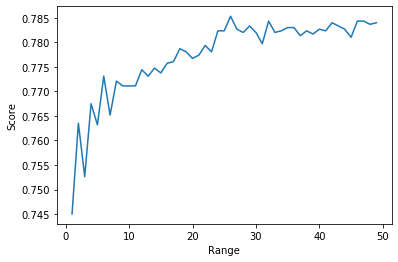

In [19]:
score_array = []
for each in range(1,50):
    rf_loop = RandomForestClassifier(n_estimators = each, random_state = 1)
    rf_loop.fit(x_train,y_train)
    score_array.append(rf_loop.score(x_val,y_val))
    
plt.plot(range(1,50),score_array)
plt.xlabel("Range")
plt.ylabel("Score")
plt.show()

In [20]:
rf_model = RandomForestClassifier(n_estimators = 26, random_state = 1) #set tree number as 26
rf_model.fit(x_train,y_train)
y_pred = rf_model.predict(x_val)
accuracy = rf_model.score(x_val,y_val)

confuse_matrix = confusion_matrix(y_val, y_pred)
print("Confusion Matrix: \n", confuse_matrix)

print("\n Random Forest accuracy is:", accuracy)

cl_rp = classification_report(y_val,y_pred)
print("\n Classification Report: \n", cl_rp)

Confusion Matrix: 
 [[2009  212]
 [ 439  372]]

 Random Forest accuracy is: 0.7852902374670184

 Classification Report: 
              precision    recall  f1-score   support

          0       0.82      0.90      0.86      2221
          1       0.64      0.46      0.53       811

avg / total       0.77      0.79      0.77      3032



#### Decision Tree Classification

In [21]:
dt_model = DecisionTreeClassifier()
dt_model.fit(x_train,y_train)
y_pred = dt_model.predict(x_val)
accuracy = dt_model.score(x_val,y_val)

confuse_matrix = confusion_matrix(y_val, y_pred)
print("Confusion Matrix: \n", confuse_matrix)

print("\n Decision Tree accuracy is:", accuracy)

cl_rp = classification_report(y_val,y_pred)
print("\n Classification Report: \n", cl_rp)

Confusion Matrix: 
 [[1830  391]
 [ 428  383]]

 Decision Tree accuracy is: 0.7298812664907651

 Classification Report: 
              precision    recall  f1-score   support

          0       0.81      0.82      0.82      2221
          1       0.49      0.47      0.48       811

avg / total       0.73      0.73      0.73      3032



#### KNN Classification

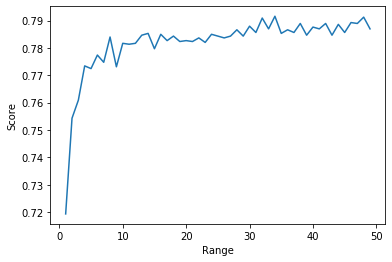

In [22]:
score_array = []
for each in range(1,50):
    knn_loop = KNeighborsClassifier(n_neighbors = each)
    knn_loop.fit(x_train,y_train)
    score_array.append(knn_loop.score(x_val,y_val))
    
plt.plot(range(1,50),score_array)
plt.xlabel("Range")
plt.ylabel("Score")
plt.show()

In [23]:
knn_model = KNeighborsClassifier(n_neighbors = 34) #set K neighbor as 34
knn_model.fit(x_train,y_train)
y_pred = knn_model.predict(x_val)
accuracy = knn_model.score(x_val,y_val)

confuse_matrix = confusion_matrix(y_val, y_pred)
print("Confusion Matrix: \n", confuse_matrix)

print("\n KNN accuracy is:", accuracy)

cl_rp = classification_report(y_val,y_pred)
print("\n Classification Report: \n", cl_rp)

Confusion Matrix: 
 [[1948  273]
 [ 359  452]]

 KNN accuracy is: 0.7915567282321899

 Classification Report: 
              precision    recall  f1-score   support

          0       0.84      0.88      0.86      2221
          1       0.62      0.56      0.59       811

avg / total       0.79      0.79      0.79      3032



#### Support Vector Machine (SVM) Classification

In [24]:
svm_model = SVC()
svm_model.fit(x_train,y_train)
y_pred = svm_model.predict(x_val)
accuracy = svm_model.score(x_val,y_val)

confuse_matrix = confusion_matrix(y_val, y_pred)
print("Confusion Matrix: \n", confuse_matrix)

print("\n SVM accuracy is:", accuracy)

cl_rp = classification_report(y_val,y_pred)
print("\n Classification Report: \n", cl_rp)

Confusion Matrix: 
 [[2036  185]
 [ 443  368]]

 SVM accuracy is: 0.7928759894459103

 Classification Report: 
              precision    recall  f1-score   support

          0       0.82      0.92      0.87      2221
          1       0.67      0.45      0.54       811

avg / total       0.78      0.79      0.78      3032



#### Naive Bayes Classification

In [25]:
naive_model = GaussianNB()
naive_model.fit(x_train,y_train)
y_pred = naive_model.predict(x_val)
accuracy = naive_model.score(x_val,y_val)

confuse_matrix = confusion_matrix(y_val, y_pred)
print("Confusion Matrix: \n", confuse_matrix)

print("\n Naive Bayes accuracy is:", accuracy)

cl_rp = classification_report(y_val,y_pred)
print("\n Classification Report: \n", cl_rp)

Confusion Matrix: 
 [[1620  601]
 [ 191  620]]

 Naive Bayes accuracy is: 0.7387862796833773

 Classification Report: 
              precision    recall  f1-score   support

          0       0.89      0.73      0.80      2221
          1       0.51      0.76      0.61       811

avg / total       0.79      0.74      0.75      3032



#### Logistic Regression Classification

In [26]:
lr_model = LogisticRegression()
lr_model.fit(x_train,y_train)
y_pred = lr_model.predict(x_val)
accuracy = lr_model.score(x_val,y_val)

confuse_matrix = confusion_matrix(y_val, y_pred)
print("Confusion Matrix: \n", confuse_matrix)

print("\n Logistic Regression accuracy is:", accuracy)

cl_rp = classification_report(y_val,y_pred)
print("\n Classification Report: \n", cl_rp)

Confusion Matrix: 
 [[2006  215]
 [ 371  440]]

 Logistic Regression accuracy is: 0.8067282321899736

 Classification Report: 
              precision    recall  f1-score   support

          0       0.84      0.90      0.87      2221
          1       0.67      0.54      0.60       811

avg / total       0.80      0.81      0.80      3032



#### Ada Boost Classifier

In [27]:
ada_model = AdaBoostClassifier()
ada_model.fit(x_train,y_train)
y_pred = ada_model.predict(x_val)
accuracy = ada_model.score(x_val,y_val)

confuse_matrix = confusion_matrix(y_val, y_pred)
print("Confusion Matrix: \n", confuse_matrix)

print("\n AdaBoost accuracy is:", accuracy)

cl_rp = classification_report(y_val,y_pred)
print("\n Classification Report: \n", cl_rp)

Confusion Matrix: 
 [[2005  216]
 [ 382  429]]

 AdaBoost accuracy is: 0.8027704485488126

 Classification Report: 
              precision    recall  f1-score   support

          0       0.84      0.90      0.87      2221
          1       0.67      0.53      0.59       811

avg / total       0.79      0.80      0.80      3032



#### XG Boost Classification

In [28]:
xgb_model = XGBClassifier()
xgb_model.fit(x_train,y_train)
y_pred = xgb_model.predict(x_val)
accuracy = xgb_model.score(x_val,y_val)

confuse_matrix = confusion_matrix(y_val, y_pred)
print("Confusion Matrix: \n", confuse_matrix)

print("\n XGBoost accuracy is:", accuracy)

cl_rp = classification_report(y_val,y_pred)
print("\n Classification Report: \n", cl_rp)

Confusion Matrix: 
 [[2012  209]
 [ 391  420]]

 XGBoost accuracy is: 0.8021108179419525

 Classification Report: 
              precision    recall  f1-score   support

          0       0.84      0.91      0.87      2221
          1       0.67      0.52      0.58       811

avg / total       0.79      0.80      0.79      3032



/home/pk/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/pk/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## Model Evaluation

In [29]:
def print_scores(headline, y_true, y_pred):
    print("\n", headline)
    acc_score = accuracy_score(y_true, y_pred)
    print("accuracy: ",acc_score)
    pre_score = precision_score(y_true, y_pred)
    print("precision: ",pre_score)
    rec_score = recall_score(y_true, y_pred)                            
    print("recall: ",rec_score)
    f_score = f1_score(y_true, y_pred, average='weighted')
    print("f1_score: ",f_score)

In [30]:
print_scores("Logistic Regression;",y_val, lr_model.predict(x_val))
print_scores("SVC;",y_val, svm_model.predict(x_val))
print_scores("KNN;",y_val, knn_model.predict(x_val))
print_scores("Naive Bayes;",y_val, naive_model.predict(x_val))
print_scores("Decision Tree;",y_val, dt_model.predict(x_val))
print_scores("Random Forest;",y_val, rf_model.predict(x_val))
print_scores("Ada Boost;",y_val, ada_model.predict(x_val))
print_scores("XGBoost;",y_val, xgb_model.predict(x_val))


 Logistic Regression;
accuracy:  0.8067282321899736
precision:  0.6717557251908397
recall:  0.5425400739827374
f1_score:  0.7997236564136679

 SVC;
accuracy:  0.7928759894459103
precision:  0.6654611211573237
recall:  0.45376078914919854
f1_score:  0.7789721747585251

 KNN;
accuracy:  0.7915567282321899
precision:  0.623448275862069
recall:  0.5573366214549939
f1_score:  0.7877008767978624

 Naive Bayes;
accuracy:  0.7387862796833773
precision:  0.5077805077805078
recall:  0.7644882860665845
f1_score:  0.7518580862995687

 Decision Tree;
accuracy:  0.7298812664907651
precision:  0.49483204134366926
recall:  0.4722564734895191
f1_score:  0.7278441557857998

 Random Forest;
accuracy:  0.7852902374670184
precision:  0.636986301369863
recall:  0.45869297163995065
f1_score:  0.7730404586624893

 Ada Boost;
accuracy:  0.8027704485488126
precision:  0.6651162790697674
recall:  0.528976572133169
f1_score:  0.7950798092502723

 XGBoost;
accuracy:  0.8021108179419525
precision:  0.6677265500794

/home/pk/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Logistic Regression gives the best model as it gives the highest accuracy and f1_score. Comparatively, AdaBoost and XGBoost are also very good models. 
Naive Bayes and Decision Tree models should be avoided as their score is very low comparatively to other models.

## Final Conclusions

 - The Major Key Factors that predict churn are:
      - Monthly Charges
      - Contract
      - tenure
      - Total Charges
      - Internet Service
      - Online Security
      
      
 - Offers to encourage the customers not to churn:
      - Customers should be encouraged to take longer period contract
      - The tenure should be increased
      - DSL internet Service is better than Fibre Optics Service
      
      
 - To determine whether the actions taken were effective make the offers to the churning customers for two months period  and see if they still want to churn after the two months.